# Modelling Results - Transfer

In this notebook, the predictions from the finetuned model are utilized. For detailed theoretical information, please refer to the report.

After training a Graph Neural Network (GNN), additional features were evaluated using a Random Forest (RF) model. Key features included GNN prediction scores, cosine similarity, and various node metrics like in-degree, out-degree, and cluster coefficients. Permutation Importance was applied to identify the most influential features. 

Permutation importance is a model-agnostic technique to evaluate feature importance by assessing the change in a model's performance after shuffling the values of a specific feature. A significant drop in performance suggests the feature is crucial for accurate predictions. This process is iterated to obtain a stable importance score.

To ensure robustness, a 5-fold cross-validation was performed on the validation set, followed by testing on the test set to verify generalization. This approach ensures that the model's performance and the selected features are reliable and effective.


In [ ]:
import os
current_dir = os.getcwd()
if os.path.basename(current_dir) != 'link-prediction-in-graphs':
    parent_dir = os.path.dirname(current_dir)
    os.chdir(parent_dir)
print(f"current working directory: {os.getcwd()}")

import torch
import numpy as np
import networkx as nx
import pandas as pd
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from ogb.nodeproppred import NodePropPredDataset
import dask.dataframe as dd
from dask.multiprocessing import get
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier,HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from ogb.linkproppred import Evaluator
from joblib import dump,load

# set default plt figsize to (12,6)
plt.rcParams["figure.figsize"] = (12,6)
pd.set_option('display.colheader_justify', 'center')
# Set default font sizes
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['axes.labelsize'] = 18 
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['legend.title_fontsize'] = 18
dataset = "ogbn-arxiv"

data_path = "./dataset/sample_data_for_evaluation_build/transfer/"
data = NodePropPredDataset(name=dataset)
from modelling.dataset_split.dataset_splitter import Dataset_Splitter

## Load Data

In [42]:
ds_split = Dataset_Splitter()
dataset_ = ds_split.load_dataset(dataset)
split_edge, edge_index = ds_split.get_edges_split(dataset_)

Creating Splits for dataset ogbn-arxiv
Returning Splits for dataset ogbn-arxiv


In [43]:
source = np.load(f"{data_path}source.npy")
source_multiplied = np.array(torch.tensor(source).view(-1, 1).repeat(1, 1000).view(-1))
target_neg = np.load(f"{data_path}target_neg.npy")
target_pos = np.load(f"{data_path}target.npy")
neg_preds = np.load(f"{data_path}neg_preds.npy")
pos_preds = np.load(f"{data_path}pos_preds.npy")

## load precalculated_data

The data used in this chapter has already been calculated in the notebook `./2_modelling_results.ipynb`, and here it is only loaded into the respective dataframes.

In [46]:
pred_pos_df_featured = pd.read_csv("./dataset/modelling_results_calc_saved/pred_pos_df_featured.csv", index_col=0)
pred_neg_df_featured = pd.read_csv("./dataset/modelling_results_calc_saved/pred_neg_df_featured.csv", index_col=0)

In [47]:
pos_preds = np.load(f"{data_path}valid_pos_preds.npy")
neg_preds = np.load(f"{data_path}valid_neg_preds.npy")
pred_pos_df_featured["prediction_model"] = pos_preds
pred_neg_df_featured["prediction_model"] = neg_preds.reshape(-1)


In [48]:
comined_pred_df_featured = pd.concat([pred_neg_df_featured,pred_pos_df_featured])

## GCN Transfer
### Overall Importances

In [17]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
model_to_select = "Random Forest"
features_to_drop = ["source","target"]
mrr_list = []
n=0
for train_index, test_index in kf.split(source):
    n+=1
    X_train = comined_pred_df_featured[comined_pred_df_featured["source"].isin(source[train_index])].copy()
    y_train = X_train.pop("output").values
    X_test = comined_pred_df_featured[comined_pred_df_featured["source"].isin(source[test_index])].copy()
    y_test = X_test.pop("output").values
    if model_to_select == "Random Forest":
        model = RandomForestClassifier(n_estimators=120, random_state=42,n_jobs = -1)
    elif model_to_select == "Logistic Regression":
        model = LogisticRegression()
    model.fit(X_train.copy().drop(columns=features_to_drop), y_train)

    X_test_pos = pred_pos_df_featured[pred_pos_df_featured["source"].isin(source[test_index])].copy().drop(columns="output")
    y_pred_pos = model.predict_proba(X_test_pos.copy().drop(columns=features_to_drop))[:,1]

    X_test_neg = pred_neg_df_featured[pred_neg_df_featured["source"].isin(source[test_index])].copy().drop(columns="output")
    y_pred_neg = model.predict_proba(X_test_neg.copy().drop(columns=features_to_drop))[:,1]

    evaluator = Evaluator(name='ogbl-citation2')
    eval_dict = evaluator.eval({
                'y_pred_pos': torch.tensor(y_pred_pos),
                'y_pred_neg': torch.tensor(y_pred_neg).view(-1,1000),
            })
    print(eval_dict["mrr_list"].mean())
    mrr_list.append(eval_dict["mrr_list"].mean())
    dump(model, f'./models_saved/transfer_random_forest_model_{n}.joblib')

tensor(0.9324)
tensor(0.9394)
tensor(0.9432)
tensor(0.9391)
tensor(0.9381)


In [ ]:
perm_importance = []
n_times = 2
for col in comined_pred_df_featured.drop(columns ="output").columns.values:
    if col not in features_to_drop:
        kf = KFold(n_splits=5, shuffle=True, random_state=42)
        saved_per_model = []
        model_n = 0
        for train_index, test_index in kf.split(source):
            model_n +=1
            model = load(f'./models_saved/transfer_random_forest_model_{model_n}.joblib')
            X_train = comined_pred_df_featured[comined_pred_df_featured["source"].isin(source[train_index])].copy()
            y_train = X_train.pop("output").values
            X_test = comined_pred_df_featured[comined_pred_df_featured["source"].isin(source[test_index])].copy()
            y_test = X_test.pop("output").values
            
            X_test_pos = pred_pos_df_featured[pred_pos_df_featured["source"].isin(source[test_index])].copy().drop(columns="output")
            X_test_neg = pred_neg_df_featured[pred_neg_df_featured["source"].isin(source[test_index])].copy().drop(columns="output")
            
            saved_per_feature = []
            for x in range(n_times):
                X_test_neg_permuted = X_test_neg.copy()
                X_test_pos_permuted = X_test_pos.copy()

                permuted_columns = np.random.permutation(np.hstack((X_test_pos_permuted[col].values,X_test_neg_permuted[col].values)))
                X_test_neg_permuted[col] = permuted_columns[:X_test_neg_permuted.shape[0]]
                X_test_pos_permuted[col] = permuted_columns[X_test_neg_permuted.shape[0]:]

                y_pred_pos = model.predict_proba(X_test_pos_permuted.copy().drop(columns=features_to_drop))[:,1]
                y_pred_neg = model.predict_proba(X_test_neg_permuted.copy().drop(columns=features_to_drop))[:,1]
                evaluator = Evaluator(name='ogbl-citation2')
                eval_dict = evaluator.eval({
                            'y_pred_pos': torch.tensor(y_pred_pos),
                            'y_pred_neg': torch.tensor(y_pred_neg).view(-1,1000),
                        })
                mrr_mean = eval_dict["mrr_list"].mean()
                importance = results[model_n-1] - mrr_mean
                saved_per_feature.append(importance)
            saved_per_model.append((np.mean(saved_per_feature)))
        perm_importance.append((col, np.mean(saved_per_model),np.std(saved_per_model)))
perm_importance.sort(key=lambda x: x[1], reverse=True)

In [ ]:
labels, values, errors = zip(*perm_importance)

# Creating the bar plot with error bars
plt.figure(figsize=(10, 8))
plt.barh(labels, values, xerr=errors, color='skyblue')
plt.xlabel('Permutation Importance MRR difference')
plt.ylabel('Features')
plt.title('Feature Importance with Standard Deviation')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest value at the top
plt.savefig("gcn_transfer_permutation_importnace_all_features.pdf", format='pdf',dpi=5000,bbox_inches='tight')
plt.show()

In [17]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
model_to_select = "Random Forest"
features_to_drop = comined_pred_df_featured.columns[~comined_pred_df_featured.columns.isin(["output","prediction_model","node_year_target","common_neighbours_all","in_degrees_target"])]
mrr_list = []
n=0
for train_index, test_index in kf.split(source):
    n+=1
   
    X_train = comined_pred_df_featured[comined_pred_df_featured["source"].isin(source[train_index])].copy()
    y_train = X_train.pop("output").values
    X_test = comined_pred_df_featured[comined_pred_df_featured["source"].isin(source[test_index])].copy()
    y_test = X_test.pop("output").values
    if model_to_select == "Random Forest":
        model = RandomForestClassifier(n_estimators=120, random_state=42,n_jobs = -1)
    elif model_to_select == "Logistic Regression":
        model = LogisticRegression()
    model.fit(X_train.copy().drop(columns=features_to_drop), y_train)
    
    X_test_pos = pred_pos_df_featured[pred_pos_df_featured["source"].isin(source[test_index])].copy().drop(columns="output")
    y_pred_pos = model.predict_proba(X_test_pos.copy().drop(columns=features_to_drop))[:,1]

    X_test_neg = pred_neg_df_featured[pred_neg_df_featured["source"].isin(source[test_index])].copy().drop(columns="output")
    y_pred_neg = model.predict_proba(X_test_neg.copy().drop(columns=features_to_drop))[:,1]

    evaluator = Evaluator(name='ogbl-citation2')
    eval_dict = evaluator.eval({
                'y_pred_pos': torch.tensor(y_pred_pos),
                'y_pred_neg': torch.tensor(y_pred_neg).view(-1,1000),
            })
    print(eval_dict["mrr_list"].mean())
    mrr_list.append(eval_dict["mrr_list"].mean())
    dump(model, f'./models_saved/transfer_random_forest_model_further_trained{n}.joblib')

tensor(0.9067)
tensor(0.9152)
tensor(0.9069)
tensor(0.9083)
tensor(0.9087)


In [49]:
mrr_list = [0.9067,0.9152,0.9069,0.9083,0.9087]
features_to_drop = comined_pred_df_featured.columns[~comined_pred_df_featured.columns.isin(["output","prediction_model","node_year_target","common_neighbours_all","in_degrees_target"])]

In [50]:
perm_importance = []
n_times = 2
for col in comined_pred_df_featured.drop(columns ="output").columns.values:
    if col not in features_to_drop:
        kf = KFold(n_splits=5, shuffle=True, random_state=42)
        saved_per_model = []
        model_n = 0
        for train_index, test_index in kf.split(source):
            model_n +=1
            model = load(f'./models_saved/transfer_random_forest_model_further_trained{model_n}.joblib')
            X_train = comined_pred_df_featured[comined_pred_df_featured["source"].isin(source[train_index])].copy()
            y_train = X_train.pop("output").values
            X_test = comined_pred_df_featured[comined_pred_df_featured["source"].isin(source[test_index])].copy()
            y_test = X_test.pop("output").values

            X_test_pos = pred_pos_df_featured[pred_pos_df_featured["source"].isin(source[test_index])].copy().drop(columns="output")

            X_test_neg = pred_neg_df_featured[pred_neg_df_featured["source"].isin(source[test_index])].copy().drop(columns="output")
            saved_per_feature = []
            for x in range(n_times):
                X_test_neg_permuted = X_test_neg.copy()
                X_test_pos_permuted = X_test_pos.copy()

                permuted_columns = np.random.permutation(np.hstack((X_test_pos_permuted[col].values,X_test_neg_permuted[col].values)))
                X_test_neg_permuted[col] = permuted_columns[:X_test_neg_permuted.shape[0]]
                X_test_pos_permuted[col] = permuted_columns[X_test_neg_permuted.shape[0]:]

                y_pred_pos = model.predict_proba(X_test_pos_permuted.copy().drop(columns=features_to_drop))[:,1]
                y_pred_neg = model.predict_proba(X_test_neg_permuted.copy().drop(columns=features_to_drop))[:,1]
                evaluator = Evaluator(name='ogbl-citation2')
                eval_dict = evaluator.eval({
                            'y_pred_pos': torch.tensor(y_pred_pos),
                            'y_pred_neg': torch.tensor(y_pred_neg).view(-1,1000),
                        })
                mrr_mean = eval_dict["mrr_list"].mean()
                importance = mrr_list[model_n-1] - mrr_mean
                saved_per_feature.append(importance)
            saved_per_model.append((np.mean(saved_per_feature)))
        perm_importance.append((col, np.mean(saved_per_model),np.std(saved_per_model)))
perm_importance.sort(key=lambda x: x[1], reverse=True)

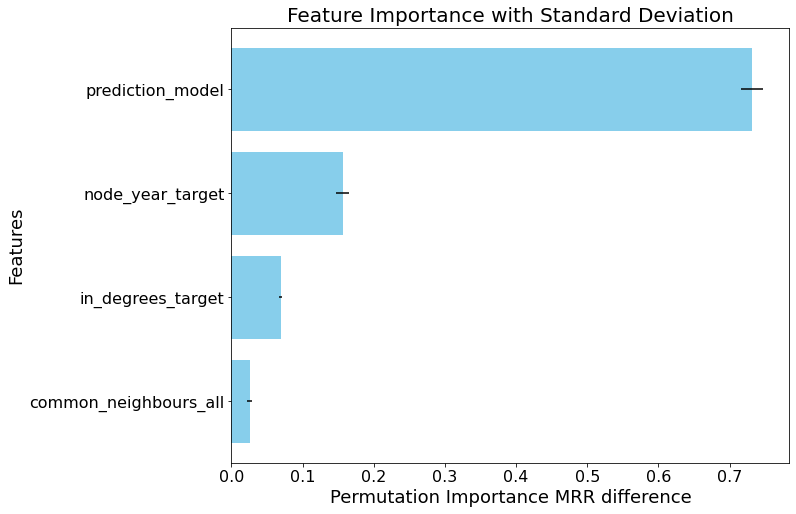

In [52]:
labels, values, errors = zip(*perm_importance)

# Creating the bar plot with error bars
plt.figure(figsize=(10, 8))
plt.barh(labels, values, xerr=errors, color='skyblue')
plt.xlabel('Permutation Importance MRR difference')
plt.ylabel('Features')
plt.title('Feature Importance with Standard Deviation')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest value at the top
plt.savefig("gcn_transfer_permutation_importnace_four_features.pdf", format='pdf',dpi=5000,bbox_inches='tight')
plt.show()

### Test on testset

Here the random forest model is trained on the validation set and tested on the testset.

In [53]:
data_path_test = "./dataset/sample_data_for_evaluation_build/gcn_reference/test/"
pos_preds_test = np.load(f"{data_path_test}pos_preds.npy")
neg_preds_test = np.load(f"{data_path_test}neg_preds.npy")
pred_pos_df_featured_test= pd.read_csv("./dataset/modelling_results_calc_saved/pred_pos_df_featured_test.csv", index_col=0)
pred_neg_df_featured_test = pd.read_csv("./dataset/modelling_results_calc_saved/pred_neg_df_featured_test.csv", index_col=0)
pred_pos_df_featured_test["prediction_model"] = pos_preds_test
pred_neg_df_featured_test["prediction_model"] = neg_preds_test.reshape(-1)
comined_pred_df_featured_test = pd.concat([pred_neg_df_featured_test,pred_pos_df_featured_test])

In [ ]:
model_to_select = "Random Forest"
features_to_drop = comined_pred_df_featured.columns[~comined_pred_df_featured.columns.isin(["output","prediction_model","node_year_target","common_neighbours_all","in_degrees_target"])]
   
X_train = comined_pred_df_featured.copy()
y_train = X_train.pop("output").values
X_test = comined_pred_df_featured_test.copy()
y_test = X_test.pop("output").values
if model_to_select == "Random Forest":
    model = RandomForestClassifier(n_estimators=120, random_state=42,n_jobs = -1)
elif model_to_select == "Logistic Regression":
    model = LogisticRegression()
model.fit(X_train.copy().drop(columns=features_to_drop), y_train)

X_test_pos = pred_pos_df_featured_test.copy().drop(columns="output")
y_pred_pos = model.predict_proba(X_test_pos.copy().drop(columns=features_to_drop))[:,1]

X_test_neg = pred_neg_df_featured_test.copy().drop(columns="output")
y_pred_neg = model.predict_proba(X_test_neg.copy().drop(columns=features_to_drop))[:,1]

evaluator = Evaluator(name='ogbl-citation2')
eval_dict = evaluator.eval({
            'y_pred_pos': torch.tensor(y_pred_pos),
            'y_pred_neg': torch.tensor(y_pred_neg).view(-1,1000),
        })

dump(model, f'./models_saved/transfer_random_forest_model_further_trained_full_data.joblib')

In [54]:
perm_importance = []
result = 0.8856 #eval_dict["mrr_list"].mean()
n_times = 5
model = load(f'./models_saved/transfer_random_forest_model_further_trained_full_data.joblib')
for col in X_test_pos.columns:
    if col not in features_to_drop:            

        saved_per_feature = []
        for x in range(n_times):
            X_test_neg_permuted = X_test_neg.copy()
            X_test_pos_permuted = X_test_pos.copy()

            permuted_columns = np.random.permutation(np.hstack((X_test_pos_permuted[col].values,X_test_neg_permuted[col].values)))
            X_test_neg_permuted[col] = permuted_columns[:X_test_neg_permuted.shape[0]]
            X_test_pos_permuted[col] = permuted_columns[X_test_neg_permuted.shape[0]:]

            y_pred_pos = model.predict_proba(X_test_pos_permuted.copy().drop(columns=features_to_drop))[:,1]
            y_pred_neg = model.predict_proba(X_test_neg_permuted.copy().drop(columns=features_to_drop))[:,1]
            evaluator = Evaluator(name='ogbl-citation2')
            eval_dict = evaluator.eval({
                        'y_pred_pos': torch.tensor(y_pred_pos),
                        'y_pred_neg': torch.tensor(y_pred_neg).view(-1,1000),
                    })
            mrr_mean = eval_dict["mrr_list"].mean()
            importance = result - mrr_mean
            saved_per_feature.append(importance)
        perm_importance.append((col, np.mean(saved_per_feature),np.std(saved_per_feature)))
perm_importance.sort(key=lambda x: x[1], reverse=True)

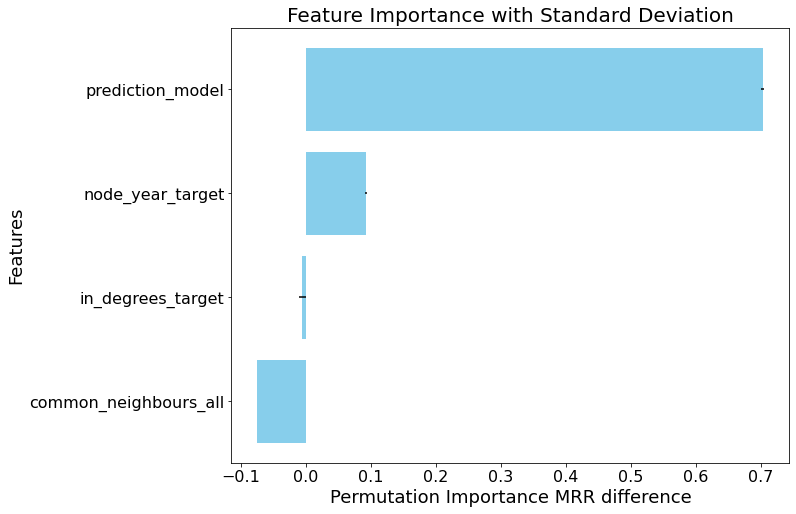

In [56]:
labels, values, errors = zip(*perm_importance)

# Creating the bar plot with error bars
plt.figure(figsize=(10, 8))
plt.barh(labels, values, xerr=errors, color='skyblue')
plt.xlabel('Permutation Importance MRR difference')
plt.ylabel('Features')
plt.title('Feature Importance with Standard Deviation')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest value at the top
plt.savefig("gcn_transfer_permutation_importnace_four_features_test.pdf", format='pdf',dpi=5000,bbox_inches='tight')
plt.show()